In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the data (You would replace these lines with actual file loading lines)
x = np.loadtxt("FFNN_tutorial_data/x_L30.txt").reshape(
    -1, 900
)  # Assuming the file is reshaped properly
y = np.loadtxt("FFNN_tutorial_data/y_L30.txt")

# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=42
)

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier
classifier.fit(x_train, y_train)

# Predict on test data
y_pred = classifier.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 52.67%


Epoch 1, Validation Loss: 0.684347502887249
Epoch 1, Training Loss: 0.6876894923773679, Validation Loss: 0.684347502887249
Training Accuracy: 50.18571428571428%, Validation Accuracy: 49.7%
Epoch 2, Validation Loss: 0.6656874772161245
Epoch 2, Training Loss: 0.6766344910318202, Validation Loss: 0.6656874772161245
Training Accuracy: 50.34285714285714%, Validation Accuracy: 49.7%
Epoch 3, Validation Loss: 0.6272658966481686
Epoch 3, Training Loss: 0.6475760524923151, Validation Loss: 0.6272658966481686
Training Accuracy: 69.7%, Validation Accuracy: 64.7%
Epoch 4, Validation Loss: 0.5893563665449619
Epoch 4, Training Loss: 0.6068647856062109, Validation Loss: 0.5893563665449619
Training Accuracy: 79.37142857142857%, Validation Accuracy: 89.7%
Epoch 5, Validation Loss: 0.551386883482337
Epoch 5, Training Loss: 0.5730743012645028, Validation Loss: 0.551386883482337
Training Accuracy: 90.8%, Validation Accuracy: 93.9%
Epoch 6, Validation Loss: 0.5313050616532564
Epoch 6, Training Loss: 0.5405

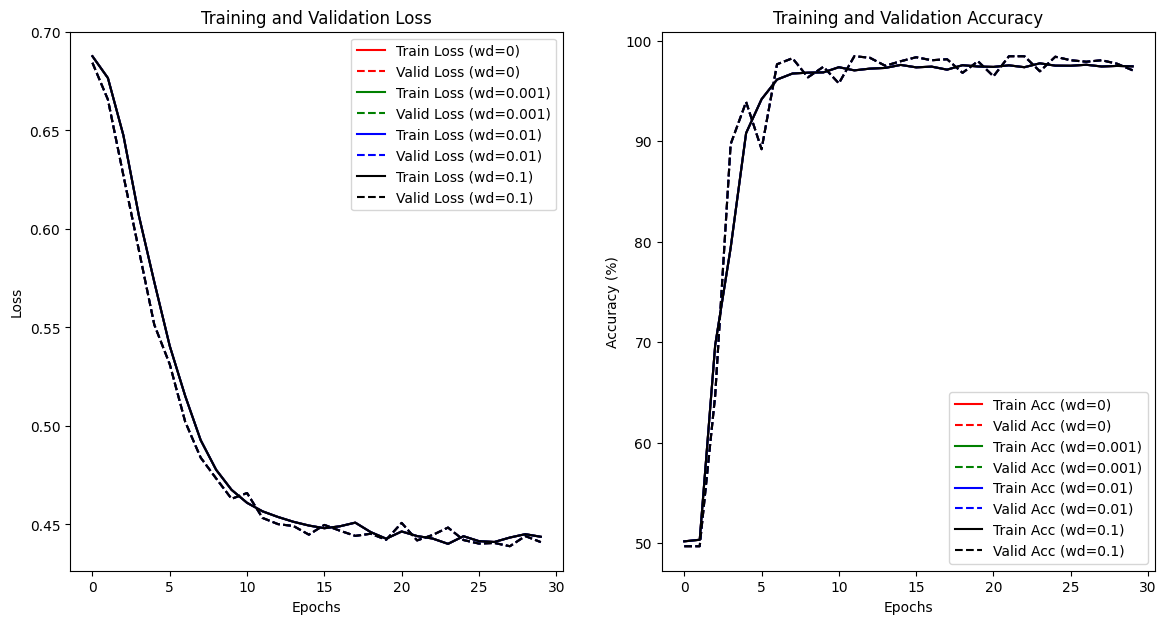

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt


# Load data
x = np.loadtxt("FFNN_tutorial_data/x_L30.txt")
y = np.loadtxt("FFNN_tutorial_data/y_L30.txt")

x_tensor = torch.Tensor(
    x.reshape(-1, 30 * 30)
)  # Reshape to match the number of features
y_tensor = torch.Tensor(y).long()

dataset = TensorDataset(x_tensor, y_tensor)

# Split the data
total_samples = len(dataset)
train_size = int(total_samples * 0.7)
validation_size = int(total_samples * 0.2)
test_size = total_samples - train_size - validation_size

train_data, validation_data, test_data = random_split(
    dataset, [train_size, validation_size, test_size]
)

# Build the Neural Network


class IsingModelClassifier(nn.Module):
    def __init__(self):
        super(IsingModelClassifier, self).__init__()
        self.fc1 = nn.Linear(30 * 30, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


weight_decay_values = [0, 0.001, 0.01, 0.1]  # Different levels of L2 regularization
# Create the model
results = {}
for weight_decay in weight_decay_values:
    model = IsingModelClassifier()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    valid_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

    training_losses, validation_losses = [], []
    training_accuracies, validation_accuracies = [], []


# Training loop
for epoch in range(30):
    training_loss, validation_loss = 0.0, 0.0
    correct_train, total_train, correct_valid, total_valid = 0, 0, 0, 0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()  # tracking of training loss here
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # validation loss

    model.eval()
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        validation_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Validation Loss: {validation_loss / len(valid_loader)}")

    # Calculate average losses
    training_losses.append(training_loss / len(train_loader))
    validation_losses.append(validation_loss / len(valid_loader))
    training_accuracies.append(100 * correct_train / total_train)
    validation_accuracies.append(100 * correct_valid / total_valid)

    print(
        f"Epoch {epoch+1}, Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}"
    )
    print(
        f"Training Accuracy: {training_accuracies[-1]}%, Validation Accuracy: {validation_accuracies[-1]}%"
    )

# Storing results in the dictionary
for weight_decay in weight_decay_values:
    # Training and evaluation logic...
    results[weight_decay] = (
        training_losses,
        validation_losses,
        training_accuracies,
        validation_accuracies,
    )

# Debugging: print out key values to check their presence and the data integrity
print("Keys in results:", results.keys())

# Plotting
colors = ["r", "g", "b", "k"]
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
for i, weight_decay in enumerate(weight_decay_values):
    train_losses, valid_losses, _, _ = results[weight_decay]
    print(
        f"Weight Decay: {weight_decay}, Train Losses: {train_losses[-1]}, Valid Losses: {valid_losses[-1]}"
    )
    plt.plot(
        train_losses,
        label=f"Train Loss (wd={weight_decay})",
        linestyle="-",
        color=colors[i],
    )
    plt.plot(
        valid_losses,
        label=f"Valid Loss (wd={weight_decay})",
        linestyle="--",
        color=colors[i],
    )
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for i, weight_decay in enumerate(weight_decay_values):
    _, _, train_accuracies, valid_accuracies = results[weight_decay]
    print(
        f"Weight Decay: {weight_decay}, Train Accuracies: {train_accuracies[-1]}, Valid Accuracies: {valid_accuracies[-1]}"
    )
    plt.plot(
        train_accuracies,
        label=f"Train Acc (wd={weight_decay})",
        linestyle="-",
        color=colors[i],
    )
    plt.plot(
        valid_accuracies,
        label=f"Valid Acc (wd={weight_decay})",
        linestyle="--",
        color=colors[i],
    )
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()


# Test the Neural Network

# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
# correct = 0
# total = 0
# model.eval()
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print(f"Accuracy of the network on the test data: {100 * correct / total}%")